In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 3.)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

In [3]:
n_rois = 68
count_offset = 100
data_path = '../sample_data/hcp_data.npy'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path)
n_subs = brain_networks.shape[0]

In [4]:
std_trans = min_max_standardize(avg_trans)
std_rotat = min_max_standardize(avg_rotat)
motion = np.concatenate([std_trans, std_rotat], axis=-1)

In [5]:
sub_ids = np.arange(len(brain_networks)).reshape(-1,1)
big_trans_ids = sub_ids[std_trans > np.quantile(std_trans, .9)]
big_rotat_ids = sub_ids[std_rotat > np.quantile(std_rotat, .9)]
small_trans_ids = sub_ids[std_trans < np.quantile(std_trans, .1)]
small_rotat_ids = sub_ids[std_rotat < np.quantile(std_rotat, .1)]

In [6]:
big_trans = std_trans[big_trans_ids].reshape(-1,1)
small_trans = std_trans[small_trans_ids].reshape(-1,1)
big_rotat = std_rotat[big_rotat_ids].reshape(-1,1)
small_rotat = std_rotat[small_rotat_ids].reshape(-1,1)

In [7]:
big_trans_nets = brain_networks[big_trans_ids]
small_trans_nets = brain_networks[small_trans_ids]
diff_trans_nets = big_trans_nets.mean(0) - small_trans_nets.mean(0)

big_rotat_nets = brain_networks[big_rotat_ids]
small_rotat_nets = brain_networks[small_rotat_ids]
diff_rotat_nets = big_rotat_nets.mean(0) - small_rotat_nets.mean(0)

In [8]:
pca = PCA(2)
obs_trans_Xt = pca.fit_transform(np.vstack([big_trans_nets, small_trans_nets]))
obs_trans_df = pd.DataFrame({"pc1": obs_trans_Xt[:,0], 
                       "pc2": obs_trans_Xt[:,1], 
                       "trans": np.vstack([big_trans, small_trans]).flatten()})
obs_rotat_Xt = pca.fit_transform(np.vstack([big_rotat_nets, small_rotat_nets]))
obs_rotat_df = pd.DataFrame({"pc1": obs_rotat_Xt[:,0], 
                       "pc2": obs_rotat_Xt[:,1], 
                       "rotat": np.vstack([big_rotat, small_rotat]).flatten()})

In [157]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = .01, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=200, lr=1e-5, device=DEVICE)

In [36]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [37]:
ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(traits[:,4]).to(torch.float32) # oral reading recognition score

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

958 107


vae

In [158]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [159]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.reg_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.reg_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 9167.927 nll: -891.755 kl: 449.703 rmse: 17.723
epoch: 0 test loss: 2200.558 nll: -6437.757 kl: 861.356 rmse: 17.640
epoch: 5 train loss: -16344.417 nll: -16815.946 kl: 16923.843 rmse: 3.056
epoch: 5 test loss: -16568.245 nll: -17023.946 kl: 17680.135 rmse: 3.208
epoch: 10 train loss: -16426.614 nll: -16885.369 kl: 16681.955 rmse: 3.003
epoch: 10 test loss: -16635.666 nll: -17081.226 kl: 16932.554 rmse: 3.191
epoch: 15 train loss: -16453.954 nll: -16903.449 kl: 16166.659 rmse: 2.982
epoch: 15 test loss: -16661.192 nll: -17097.552 kl: 16436.722 rmse: 3.166
epoch: 20 train loss: -16470.022 nll: -16910.354 kl: 15778.901 rmse: 2.954
epoch: 20 test loss: -16676.960 nll: -17104.204 kl: 16067.899 rmse: 3.133
epoch: 25 train loss: -16482.252 nll: -16913.750 kl: 15471.352 rmse: 2.924
epoch: 25 test loss: -16688.261 nll: -17106.992 kl: 15780.750 rmse: 3.098
epoch: 30 train loss: -16492.638 nll: -16915.477 kl: 15223.594 rmse: 2.891
epoch: 30 test loss: -16698.238 nll: -17108.

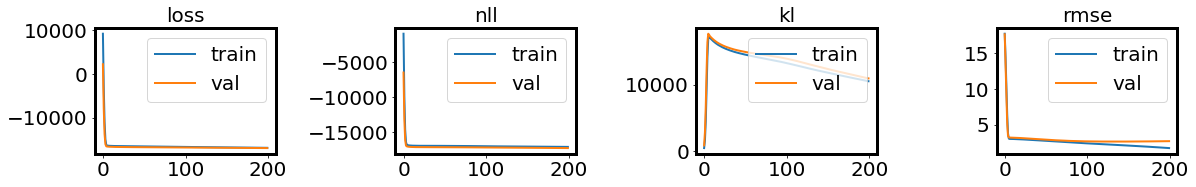

In [160]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [161]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_recon = x_recon*count_offset

In [162]:
big_trans_recon = x_recon[big_trans_ids]
small_trans_recon = x_recon[small_trans_ids]
diff_trans_recon = big_trans_recon.mean(0) - small_trans_recon.mean(0)

big_rotat_recon = x_recon[big_rotat_ids]
small_rotat_recon = x_recon[small_rotat_ids]
diff_rotat_recon = big_rotat_recon.mean(0) - small_rotat_recon.mean(0)

In [163]:
big_trans_latents = vae_latents[big_trans_ids]
small_trans_latents = vae_latents[small_trans_ids]
big_rotat_latents = vae_latents[big_rotat_ids]
small_rotat_latents = vae_latents[small_rotat_ids]

In [164]:
pca = PCA(2)
vae_trans_Xt = pca.fit_transform(np.vstack([big_trans_latents, small_trans_latents]))
vae_trans_df = pd.DataFrame({"pc1": vae_trans_Xt[:,0], 
                       "pc2": vae_trans_Xt[:,1], 
                       "trans": np.vstack([big_trans, small_trans]).flatten()})
vae_rotat_Xt = pca.fit_transform(np.vstack([big_rotat_latents, small_rotat_latents]))
vae_rotat_df = pd.DataFrame({"pc1": vae_rotat_Xt[:,0], 
                       "pc2": vae_rotat_Xt[:,1], 
                       "rotat": np.vstack([big_rotat, small_rotat]).flatten()})

inv-vae

In [118]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0., 
    beta = 1., gamma = .01, add_reg = True, y_dim = 1,
    batch_size=64, n_epochs=200, lr=5e-6, device=DEVICE)

In [119]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [120]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.reg_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.reg_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 10245.274 nll: 1683.075 kl: 289.142 inv_loss: 2.931 rmse: 17.885
epoch: 0 test loss 9638.604 nll: -1935.082 kl: 442.164 inv_loss: 5.081 rmse: 18.653
epoch: 5 train loss: 2039.029 nll: -15896.169 kl: 9214.885 inv_loss: 6.827 rmse: 8.255
epoch: 5 test loss 1571.713 nll: -16461.092 kl: 10846.060 inv_loss: 7.588 rmse: 7.906
epoch: 10 train loss: 138.669 nll: -16811.401 kl: 20244.614 inv_loss: 1.860 rmse: 3.071
epoch: 10 test loss 110.485 nll: -17012.499 kl: 20882.230 inv_loss: 2.104 rmse: 3.200
epoch: 15 train loss: 123.630 nll: -16864.140 kl: 20886.460 inv_loss: 1.356 rmse: 2.996
epoch: 15 test loss 98.469 nll: -17057.427 kl: 21362.386 inv_loss: 1.528 rmse: 3.140
epoch: 20 train loss: 121.633 nll: -16884.439 kl: 20898.003 inv_loss: 1.207 rmse: 2.987
epoch: 20 test loss 96.468 nll: -17077.770 kl: 21315.044 inv_loss: 1.359 rmse: 3.130
epoch: 25 train loss: 119.380 nll: -16896.807 kl: 20982.909 inv_loss: 1.136 rmse: 2.977
epoch: 25 test loss 94.330 nll: -17090.316 kl: 21

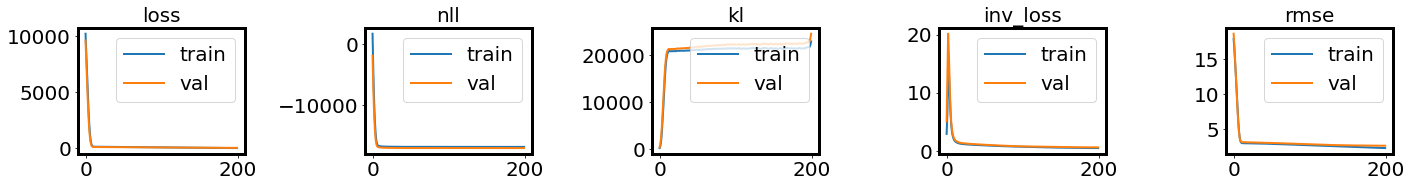

In [121]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')
axes[4].legend(loc=1)

plt.tight_layout()
plt.show()

In [122]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()

x_denoised = inv_model.decode(z_sample, 
                      torch.zeros_like(tensor_motion).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_denoised = x_denoised*count_offset

In [123]:
big_trans_denoised = x_denoised[big_trans_ids]
small_trans_denoised = x_denoised[small_trans_ids]
diff_trans_denoised = big_trans_denoised.mean(0) - small_trans_denoised.mean(0)

big_rotat_denoised = x_denoised[big_rotat_ids]
small_rotat_denoised = x_denoised[small_rotat_ids]
diff_rotat_denoised = big_rotat_denoised.mean(0) - small_rotat_denoised.mean(0)

In [124]:
big_trans_inv_latents = inv_latents[big_trans_ids]
small_trans_inv_latents = inv_latents[small_trans_ids]
big_rotat_inv_latents = inv_latents[big_rotat_ids]
small_rotat_inv_latents = inv_latents[small_rotat_ids]

In [125]:
pca = PCA(2)
inv_vae_trans_Xt = pca.fit_transform(np.vstack([big_trans_inv_latents, small_trans_inv_latents]))
inv_vae_trans_df = pd.DataFrame({"pc1": inv_vae_trans_Xt[:,0], 
                       "pc2": inv_vae_trans_Xt[:,1], 
                       "trans": np.vstack([big_trans, small_trans]).flatten()})
inv_vae_rotat_Xt = pca.fit_transform(np.vstack([big_rotat_inv_latents, small_rotat_inv_latents]))
inv_vae_rotat_df = pd.DataFrame({"pc1": inv_vae_rotat_Xt[:,0], 
                       "pc2": inv_vae_rotat_Xt[:,1], 
                       "rotat": np.vstack([big_rotat, small_rotat]).flatten()})

plotting

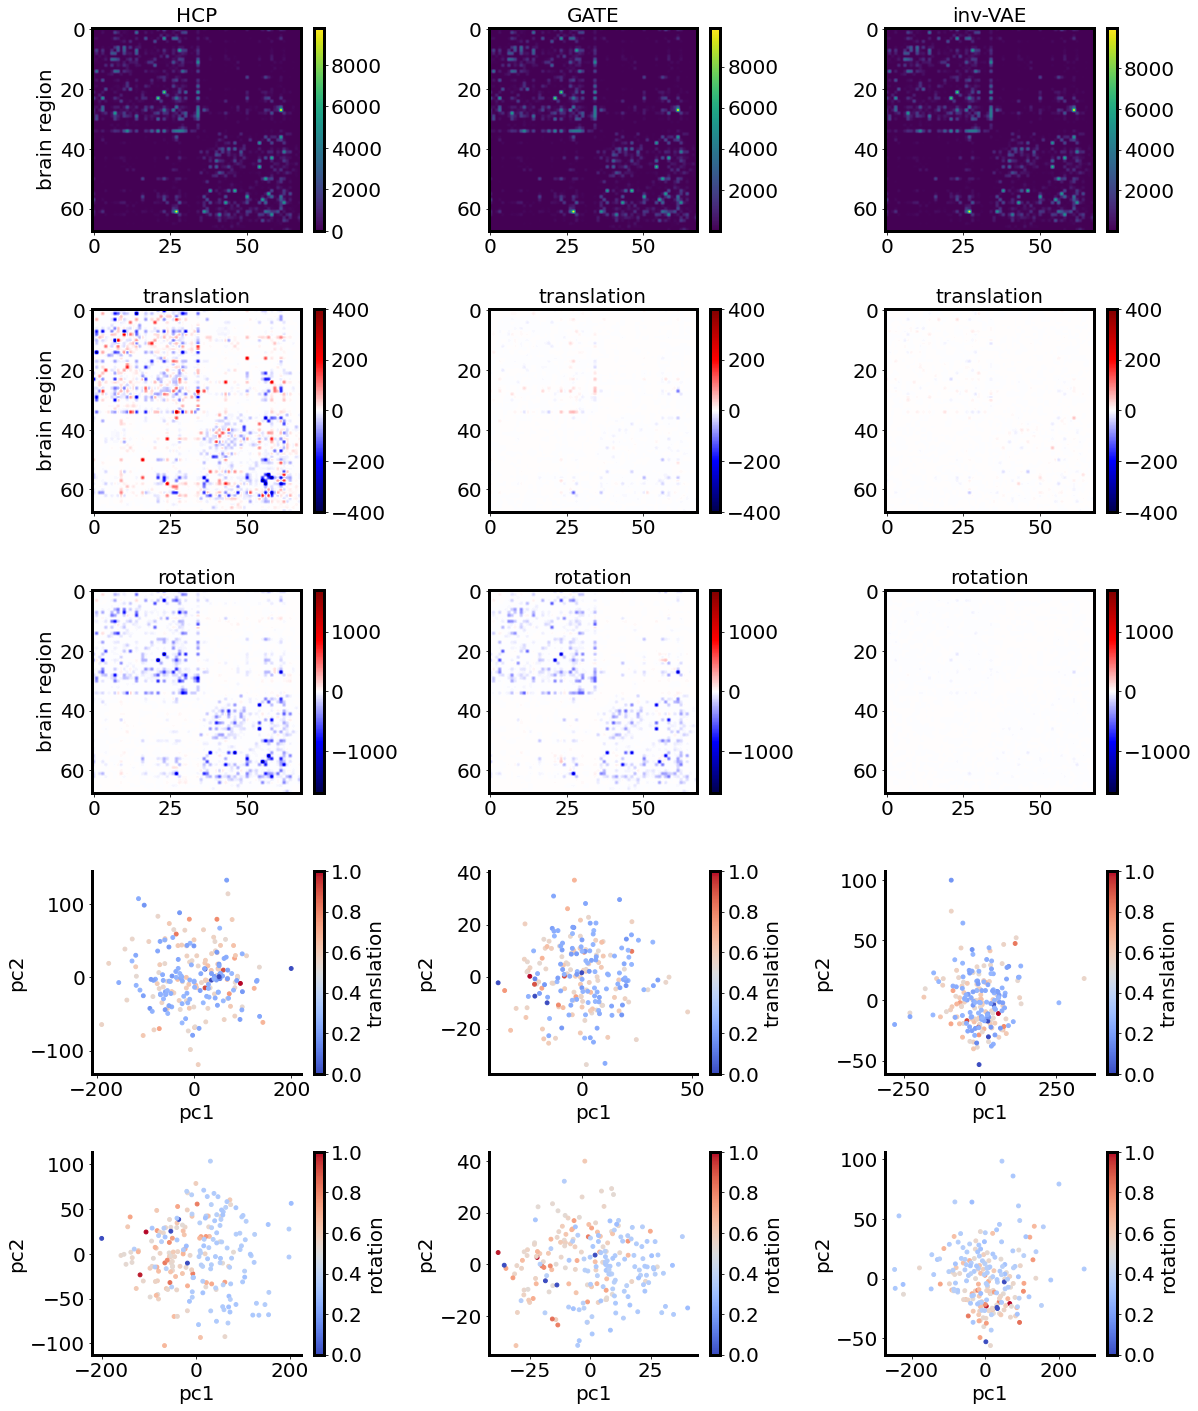

In [201]:
fig, axes = plt.subplots(5, 3, figsize=(17, 20))

p1 = axes[0,0].imshow(brain_networks.mean(0).reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap='viridis')
axes[0,0].set_title('HCP')
axes[0,0].set_ylabel('brain region')
cbar = plt.colorbar(p1, ax=axes[0,0])

p2 = axes[1,0].imshow(diff_trans_nets.reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap='seismic', vmin=-400, vmax=400)
axes[1,0].set_title('translation')
axes[1,0].set_ylabel('brain region')
cbar = plt.colorbar(p2, ax=axes[1,0])

p3 = axes[2,0].imshow(diff_rotat_nets.reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap='seismic', vmin=-1700, vmax=1700)
axes[2,0].set_title('rotation')
axes[2,0].set_ylabel('brain region')
cbar = plt.colorbar(p3, ax=axes[2,0])

p4 = axes[3,0].scatter(x="pc1", y="pc2", c="trans", cmap='coolwarm', data=obs_trans_df, s=15, alpha=1.)
axes[3,0].set_xlabel('pc1')
axes[3,0].set_ylabel('pc2')
axes[3,0].spines['top'].set_visible(False)
axes[3,0].spines['right'].set_visible(False)
cbar = plt.colorbar(p4, ax=axes[3,0], label="translation")

p5 = axes[4,0].scatter(x="pc1", y="pc2", c="rotat", cmap='coolwarm', data=obs_rotat_df, s=15, alpha=1.)
axes[4,0].set_xlabel('pc1')
axes[4,0].set_ylabel('pc2')
axes[4,0].spines['top'].set_visible(False)
axes[4,0].spines['right'].set_visible(False)
cbar = plt.colorbar(p5, ax=axes[4,0], label="rotation")

p6 = axes[0,1].imshow(x_recon.mean(0), aspect='auto', cmap='viridis')
axes[0,1].set_title('GATE')
cbar = plt.colorbar(p6, ax=axes[0,1])

p7 = axes[1,1].imshow(diff_trans_recon, aspect='auto', cmap='seismic', vmin=-400, vmax=400)
axes[1,1].set_title('translation')
cbar = plt.colorbar(p7, ax=axes[1,1])

p8 = axes[2,1].imshow(diff_rotat_recon.reshape(n_rois,n_rois), 
                      aspect='auto', cmap='seismic', vmin=-1700, vmax=1700)
axes[2,1].set_title('rotation')
cbar = plt.colorbar(p8, ax=axes[2,1])

p9 = axes[3,1].scatter(x="pc1", y="pc2", c="trans", cmap='coolwarm', data=vae_trans_df, s=15, alpha=1.)
axes[3,1].set_xlabel('pc1')
axes[3,1].set_ylabel('pc2')
axes[3,1].spines['top'].set_visible(False)
axes[3,1].spines['right'].set_visible(False)
cbar = plt.colorbar(p9, ax=axes[3,1], label="translation")

p10 = axes[4,1].scatter(x="pc1", y="pc2", c="rotat", cmap='coolwarm', data=vae_rotat_df, s=15, alpha=1.)
axes[4,1].set_xlabel('pc1')
axes[4,1].set_ylabel('pc2')
axes[4,1].spines['top'].set_visible(False)
axes[4,1].spines['right'].set_visible(False)
cbar = plt.colorbar(p10, ax=axes[4,1], label="rotation")

p11 = axes[0,2].imshow(x_denoised.mean(0), aspect='auto', cmap='viridis')
axes[0,2].set_title('inv-VAE')
cbar = plt.colorbar(p11, ax=axes[0,2])

p12 = axes[1,2].imshow(diff_trans_denoised, aspect='auto', cmap='seismic', vmin=-400, vmax=400)
axes[1,2].set_title('translation')
cbar = plt.colorbar(p12, ax=axes[1,2])

p13 = axes[2,2].imshow(diff_rotat_denoised.reshape(n_rois,n_rois), 
                      aspect='auto', cmap='seismic', vmin=-1700, vmax=1700)
axes[2,2].set_title('rotation')
cbar = plt.colorbar(p13, ax=axes[2,2])

p14 = axes[3,2].scatter(x="pc1", y="pc2", c="trans", cmap='coolwarm', data=inv_vae_trans_df, s=15, alpha=1.)
axes[3,2].set_xlabel('pc1')
axes[3,2].set_ylabel('pc2')
axes[3,2].spines['top'].set_visible(False)
axes[3,2].spines['right'].set_visible(False)
cbar = plt.colorbar(p14, ax=axes[3,2], label="translation")

p15 = axes[4,2].scatter(x="pc1", y="pc2", c="rotat", cmap='coolwarm', data=inv_vae_rotat_df, s=15, alpha=1.)
axes[4,2].set_xlabel('pc1')
axes[4,2].set_ylabel('pc2')
axes[4,2].spines['top'].set_visible(False)
axes[4,2].spines['right'].set_visible(False)
cbar = plt.colorbar(p15, ax=axes[4,2], label="rotation")

plt.tight_layout()
plt.savefig('saved_figs/fig5_hcp_correct_motion.png', facecolor='white', dpi=800)

circular connectivity plots:

unfortunately, i am having trouble with plotting multiple circular connectivity plots using mne,\
so i have to plot each circ plot separately :(

In [166]:
cmap = plt.cm.tab20c

labels = {
    'bankssts': cmap(0),
    'caudalanteriorcingulate': cmap(1),
    'caudalmiddlefrontal': cmap(1),
    'cuneus': cmap(2),
    'entorhinal': cmap(3),
    'fusiform': cmap(4),
    'inferiorparietal': cmap(5),
    'inferiortemporal': cmap(5),
    'isthmuscingulate': cmap(6),
    'lateraloccipital': cmap(7),
    'lateralorbitofrontal': cmap(7),
    'lingual': cmap(8),
    'medialorbitofrontal': cmap(9),
    'middletemporal': cmap(10),
    'parahippocampal': cmap(11),
    'paracentral': cmap(11),
    'parsopercularis': cmap(11),
    'parsorbitalis': cmap(11),
    'parstriangularis': cmap(11),
    'pericalcarine': cmap(12),
    'postcentral': cmap(13),
    'posteriorcingulate': cmap(13),
    'precentral': cmap(14),
    'precuneus': cmap(14),
    'rostralanteriorcingulate': cmap(15),
    'rostralmiddlefrontal': cmap(15),
    'superiorfrontal': cmap(16),
    'superiorparietal': cmap(16),
    'superiortemporal': cmap(16),
    'supramarginal': cmap(16),
    'frontalpole': cmap(16),
    'temporalpole': cmap(17),
    'transversetemporal': cmap(18),
    'insula': cmap(19)
}

label_colors = list()
label_colors.extend(list(labels.values())[::-1])  
label_colors.extend(list(labels.values()))

lh_labels = ['lh-' + label for label in labels.keys()]
rh_labels = ['rh-' + label for label in labels.keys()]

node_order = list()
node_order.extend(lh_labels[::-1])  
node_order.extend(rh_labels)

node_angles = circular_layout(node_order, node_order, start_pos=90,
                              group_boundaries=[0, len(node_order) / 2])

In [190]:
diff_trans_adjusted = big_trans_denoised.mean(0).flatten() - big_trans_nets.mean(0)
diff_rotat_adjusted = big_rotat_denoised.mean(0).flatten() - big_rotat_nets.mean(0)

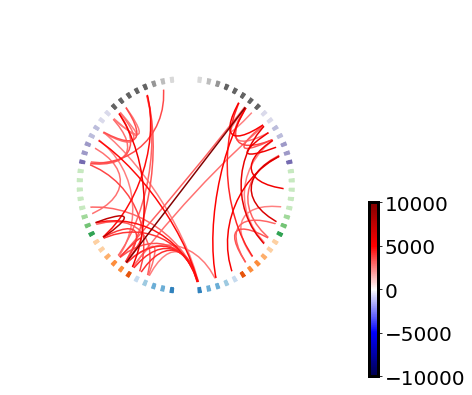

In [197]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white',
                       subplot_kw=dict(polar=True))
fig, ax = plot_connectivity_circle(
                         diff_trans_adjusted.reshape(n_rois,n_rois), 
                         node_angles=node_angles,
                         node_colors=label_colors,
                         facecolor='white',
                         textcolor='black', 
                         node_edgecolor='white',
                         colormap='seismic',
                         node_height=1.,
                         node_linewidth=5.,
                         vmin=-1_0000,
                         vmax=1_0000,
                         node_names=['' for i in range(n_rois)], 
                         colorbar=True,
                         colorbar_size=.4,
                         fontsize_colorbar=20,
                         n_lines=50, ax=ax)
fig.tight_layout()
fig.savefig('saved_figs/fig6_hcp_trans_adjust.png', facecolor='white', dpi=300)

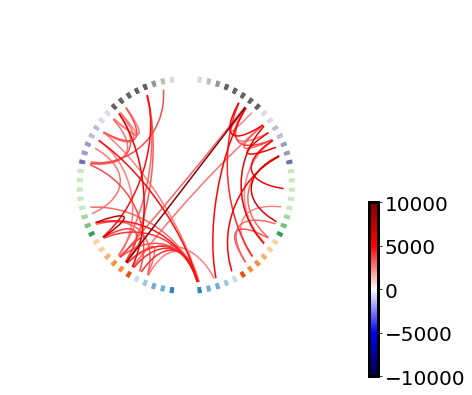

In [198]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white',
                       subplot_kw=dict(polar=True))
fig, ax = plot_connectivity_circle(
                         diff_rotat_adjusted.reshape(n_rois,n_rois), 
                         node_angles=node_angles,
                         node_colors=label_colors,
                         facecolor='white',
                         textcolor='black', 
                         node_edgecolor='white',
                         colormap='seismic',
                         node_height=1.,
                         node_linewidth=5.,
                         vmin=-1_0000,
                         vmax=1_0000,
                         node_names=['' for i in range(n_rois)], 
                         colorbar=True,
                         colorbar_size=.4,
                         fontsize_colorbar=20,
                         n_lines=50, ax=ax)
fig.tight_layout()
fig.savefig('saved_figs/fig6_hcp_rotat_adjust.png', facecolor='white', dpi=300)